# Case Study : Pneumonia Detection Using X-ray Images

<b>Objective:</b><br>
    Classify the images into two different groups using different ML techniques. Detect Pneumonia using the X-ray Image.

<b>Problem Statement :</b><br>
    Given the X-ray Image,detect if a person is having Pneumonia or not.<br><br>
    The given dataset is organized into 3 folders (train, test, val) and contains subfolders for each image
category (Pneumonia/Normal). There are total of 5,856 X-Ray images (JPEG) and 2 categories(Pneumonia/Normal).Train data consists of 5216 images out of which 3875 is of Pneumonia and 1341 is of normal.
Test data consists of 234 normal images and 390 Pneumonia images. This should be grouped to two classes by applying different algorithms and if we are given an image the model should be able to predict whether the image belongs to Pneumonia or Normal class.

<b>Libraries used:</b><br>
    cv2<br>
    numpy<br>
    matplotlib<br>
    tqdm<br>
    imblearn<br>
    sklearn<br>
    seaborn<br>
    

<b>Procedure:</b><br>
    1.Import the libraries.<br>
    2.Read the images as grayscale image.<br>
    3.Convert the images to numeric data.<br>
    4.Resize and Flatten the image<br>
    5.Applied SVM with weighted class on imbalanced data <br>
    6.Since the train data is unbalanced we need to do sampling.<br>
    7.Apply PCA on the sampled images.<br>
    8.Fine tune the hyperparameters using validation data.<br>
    9.Fit the train data to different classification models.<br>
    10.Compute the predictions using test data.<br>
    11.Find the Accuracy,Precision,Recall and AUC Score.<br>
    12.Applied CNN Model<br>
    13.Conclusion

<b>Python Code</b>

In [1]:
#ignore the warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
#Importing necessary libraries
import os
os.chdir('C:/Users/sreepa/Downloads')
#to perform computer vision problems.(work with images)
import cv2
#import pickle
#for numerical operations
import numpy as np
#visualisation
import matplotlib.pyplot as plt
#visualisation
import seaborn as sns
#to read the directory and display the progress bar
from tqdm import tqdm
#for upsampling
from imblearn.over_sampling import SMOTE
#for downsampling
from imblearn.under_sampling import RandomUnderSampler
#to perform PCA
from sklearn.decomposition import PCA
#metrics for classification problems
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
#to plot roc_auc curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
#to plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix
#to perform SVM
from sklearn import svm
#GridSerachCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
#Classification using RandomForest
from sklearn.ensemble import RandomForestClassifier
#sklearn : for DecisionTreeClassification
from sklearn.tree import DecisionTreeClassifier
#sklearn : for KNN Algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Helper function for reading the images:<br>
In the load_images function, we will do the following:<br>
        - load the image
        - resize the image to 240*240
        - convert the image to greyscale
        - Flatten the image

In [3]:
#Helper function for reading images
def load_images(path,label):
    files = np.array(os.listdir(path))
    labels = np.array([label]*len(files))
    
    images = []
    for image in tqdm(files):
        image = cv2.imread(path + image)
        image = cv2.resize(image, dsize=(240,240))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image=image.flatten()
        images.append(image)
        
    images = np.array(images)
    
    return images,labels

In [4]:
#Reading the Train Images
norm_images, norm_labels = load_images("C://Users//sreepa//Downloads//train//NORMAL//",'normal')
pneu_images, pneu_labels = load_images("C://Users//sreepa//Downloads//train//PNEUMONIA//",'pneumonia')
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)


100%|█████████████████████████████████████████████████████████████████████████████| 3875/3875 [00:23<00:00, 163.90it/s]


Train dataset consists of total 5216 images out of which 1341 are of normal and 3875 images are of Pneumonia patients.

<b>Displaying few images: </b> <br>
    The below code displays few images of the preprocessed train data. Now all the images has same dimensions.

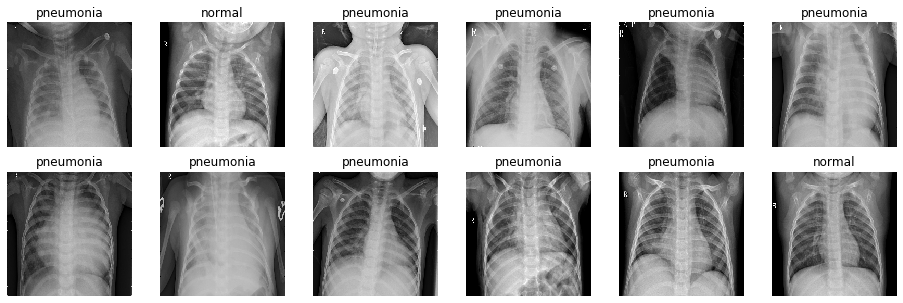

In [5]:
#Plotting few images in Train data
plt.figure(figsize=(16,16))
for n, i in enumerate ((np.random.randint(0,len(X_train),12))):
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i].reshape(240,240),cmap='gray')
    plt.title((y_train[i]))
    plt.axis("off")

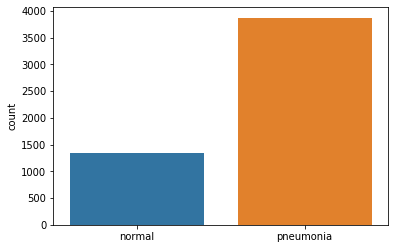

In [6]:
#Countplot of train labels
sns.countplot(y_train)

<b>Observation</b> <br>
Number of Pneumonia images are very high compared to normal images.ie,Dataset is highly imbalanced . So we need to balance the dataset by upsampling or downsampling.

In [7]:
#Mapping 'normal' as 0 and 'pnemonia' as 1
for i in range(len(y_train)):
    if y_train[i]=='normal':
        y_train[i]=0
    else:
        y_train[i]=1

In [8]:
#Reading Test Images
test_norm_images, test_norm_labels = load_images("C://Users//sreepa//Downloads//test//test//NORMAL//",'normal')
test_pneu_images, test_pneu_labels = load_images("C://Users//sreepa//Downloads//test//test//PNEUMONIA//",'pneumonia')
X_test = np.append(test_norm_images, test_pneu_images, axis=0)
y_test = np.append(test_norm_labels, test_pneu_labels)

100%|███████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 189.77it/s]


Out of 624 test images , 234 images are of Normal and rest 390 are of Pneumonia detected images.

(array(['normal', 'pneumonia'], dtype='<U9'), array([234, 390], dtype=int64))

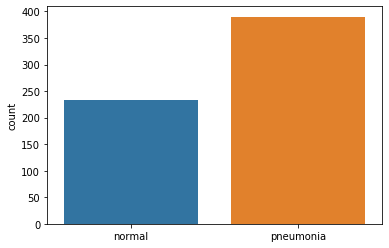

In [9]:
#Count Plot of test labels
sns.countplot(y_test)
np.unique(y_test,return_counts=True)

In [10]:
#Mapping 'normal' as 0 and 'pnemonia' as 1 for test dataset.
for i in range(len(y_test)):
    if y_test[i]=='normal':
        y_test[i]=0
    else:
        y_test[i]=1

In [11]:
#Reading Validation Images
val_norm_images, val_norm_labels = load_images("C://Users//sreepa//Downloads//validate//val//NORMAL//",'normal')
val_pneu_images, val_pneu_labels = load_images("C://Users//sreepa//Downloads//validate//val//PNEUMONIA//",'pneumonia')
X_val = np.append(val_norm_images, val_pneu_images, axis=0)
y_val = np.append(val_norm_labels, val_pneu_labels)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 162.29it/s]


Validation dataset consists of 8 each images in Normal and Pneumonia.

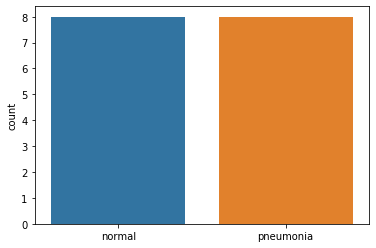

In [12]:
#Plot of validation data labels.
sns.countplot(y_val)

In [13]:
#Mapping 'normal' as 0 and 'pnemonia' as 1 for validation dataset.
for i in range(len(y_val)):
    if y_val[i]=='normal':
        y_val[i]=0
    else:
        y_val[i]=1

In [14]:
#Helper function for displaying Confusion Matrix and Accuracy Score
def evaluate_model(yt,yp):
    cf=confusion_matrix(yt,yp)
    acc=accuracy_score(yt,yp)
    return cf,acc
# Display metrics
def display_model(yt,yp,model):
    cf,acc = evaluate_model(yt,yp)
    print('########## Model= ',model,'#############','\n\nConfusion matrix:cf=\n',cf,'\n\nAccuracy Score:acc=',acc,'\n')

In [15]:
#Helper function for plotting ROC Curve and AUC Score
def roc(yt,ypred):
    fpr, tpr, thresholds = roc_curve(yt, ypred,pos_label='1')
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    auc_score = roc_auc_score(yt, ypred)
    print("AUC Score is :",auc_score)

<b>SVM with Weighted Classes: For Imbalanced Dataset</b>

Since this is an imbalanced dataset, I have tried SVM with weighted class. Added the class_weight as 'balanced'.
In support vector machines, C is a hyperparameter determining the penalty for misclassifying an observation.
In scikit-learn, when using SVC we can set the values for Cj automatically by setting class_weight='balanced'.

########## Model=  SVC with Weighted class:Testing ############# 

Confusion matrix:cf=
 [[110 124]
 [ 49 341]] 

Accuracy Score:acc= 0.7227564102564102 



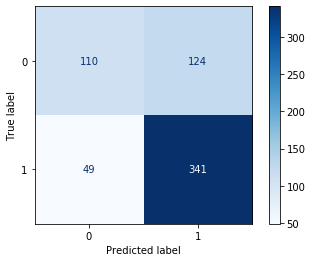

Classification Report : 
               precision    recall  f1-score   support

           0       0.69      0.47      0.56       234
           1       0.73      0.87      0.80       390

   micro avg       0.72      0.72      0.72       624
   macro avg       0.71      0.67      0.68       624
weighted avg       0.72      0.72      0.71       624
 


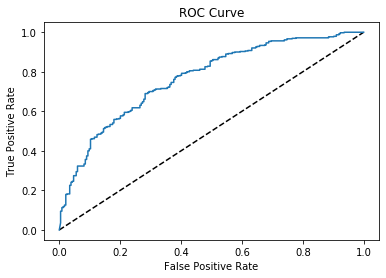

Threshold value is: 0.9713774455362555
AUC Score is : 0.766480385711155


In [16]:
#SVM with Weighted Class
clas=svm.SVC(gamma=0.0001,kernel='linear',class_weight='balanced',probability=True,random_state=42)
pca = PCA(n_components=624,svd_solver='randomized')
X_train_pc = pca.fit_transform(X_train)
X_test_pc = pca.fit_transform(X_test)
clas.fit(X_train_pc,y_train)
y_pred_p = clas.predict(X_test_pc)
display_model(y_test,y_pred_p,'SVC with Weighted class:Testing')
plot_confusion_matrix(clas, X_test_pc,y_test,cmap=plt.cm.Blues) 
plt.show()  
print("Classification Report : \n %s " % classification_report(y_test, y_pred_p, labels=[0,1]))
y_pred_prob5 = clas.predict_proba(X_test_pc)[:,1]
roc(y_test,y_pred_prob5)

<b>Observation:</b> Out of 390 Pneumonia images 341 has been classified correctly. Acuracy Score is 72% and AUC Score is 76 %

<b>SMOTE and SVM applied on SMOTE data

One way to solve the imbalance data problem is to oversample the the minority class. This can be achieved by duplicating the samples from the minority class in the training dataset before fitting the model.Here I am using SMOTE(Synthetic Minority Oversampling technique) for oversampling.

In [17]:
#UpSampling #SMOTE applied in Train data
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

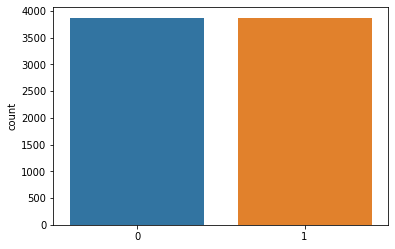

In [18]:
#Plot of labels after SMOTE
sns.countplot(y_train_smt)

In [19]:
np.unique(y_train_smt,return_counts=True)

(array(['0', '1'], dtype='<U9'), array([3875, 3875], dtype=int64))

<b>Observation:</b> After applying SMOTE train data has 3875 samples for both normal and pneumonia classes.

<b>PCA:</b>The dataset have over 40000 features for each image and 7750 images in total. To use an SVM,the number of features needs to be reduced.

PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components.Components are reduced to 624 using PCA.

In [20]:
#PCA on Upsampled data : for scaling
pca = PCA(n_components=624,svd_solver='randomized')
#pca = PCA(n_components=624)
X_train_smt_pca = pca.fit_transform(X_train_smt)

In [21]:
# Create a classifier: a support vector classifier
svm_smt = svm.SVC(gamma=0.001,kernel='sigmoid',random_state=42,probability=True)
svm_smt.fit(X_train_smt_pca,y_train_smt)

SVC(gamma=0.001, kernel='sigmoid', probability=True, random_state=42)

In [22]:
#Applied PCA on test data
X_test_PCA = pca.transform(X_test)

########## Model=  SVC for SMOTE train data:Testing ############# 

Confusion matrix:cf=
 [[124 110]
 [135 255]] 

Accuracy Score:acc= 0.6073717948717948 



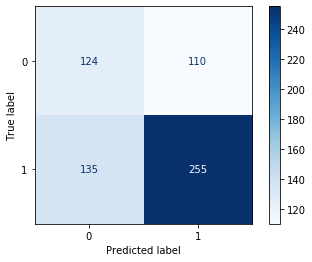

Classification Report : 
               precision    recall  f1-score   support

           0       0.48      0.53      0.50       234
           1       0.70      0.65      0.68       390

   micro avg       0.61      0.61      0.61       624
   macro avg       0.59      0.59      0.59       624
weighted avg       0.62      0.61      0.61       624
 


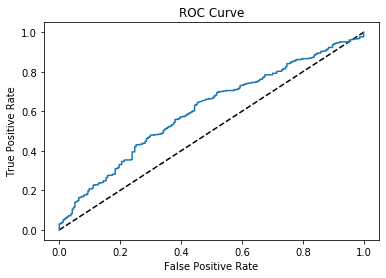

Threshold value is: 0.5069832862395944
AUC Score is : 0.6049802761341223


In [23]:
y_pred_smt = svm_smt.predict(X_test_PCA)
display_model(y_test,y_pred_smt,'SVC for SMOTE train data:Testing')
plot_confusion_matrix(svm_smt, X_test_PCA,y_test,cmap=plt.cm.Blues) 
plt.show()  
print("Classification Report : \n %s " % classification_report(y_test, y_pred_smt, labels=[0,1]))
y_pred_prob6 = svm_smt.predict_proba(X_test_PCA)[:,1]
roc(y_test,y_pred_prob6)

<b>Observation:</b><br>After doing Upsampling the Accuracy score is .60, which is low.Recall for Pneumonia is also low,65%. So I tried downsampling.

# <b>Downsampling

Another method for balancing the dataset is downsampling. Downsampling means reducing the number of samples of the majority class.<br>
Here I am using RandomUnderSampler for downsampling.

In [24]:
#DownSampling
#under = RandomUnderSampler(sampling_strategy=0.5)
under = RandomUnderSampler()
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

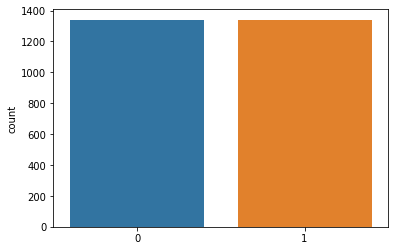

In [25]:
#Plot of labels after downsampling.
sns.countplot(y_train_under)

In [26]:
np.unique(y_train_under,return_counts=True)

(array(['0', '1'], dtype='<U9'), array([1341, 1341], dtype=int64))

After downsampling both normal and pneumonia have 1341 images.

<b>PCA:</b> After downsampling PCA is applied to the dataset for dimensionality reduction. Number of features before applying PCA is 40000 .After applying PCA the number of features will reduce to 624.

In [27]:
#Dimensionality Reduction on train data
pca = PCA(n_components=624,svd_solver='randomized')
X_train_PCA = pca.fit_transform(X_train_under)
print('PCA Explained variance:',(pca.explained_variance_ratio_).sum())

PCA Explained variance: 0.9512192209689241


In [28]:
#Applied PCA on test data
X_test_PCA = pca.transform(X_test)

In [29]:
#Applying PCA on validation data
X_val_PCA = pca.transform(X_val)

# SVM

SVM is a binary classifier based on supervised learning. SVM classifies between two classes by constructing a hyperplane in high-dimensional feature space which can be used for classification.

In [30]:
classifier=svm.SVC(kernel='linear',random_state=42)

In [31]:
classifier.fit(X_train_PCA,y_train_under)
y_pred_test = classifier.predict(X_test_PCA)
print("Confusion matrix:\n%s" % confusion_matrix(y_test, y_pred_test))
print(accuracy_score(y_test,y_pred_test))

Confusion matrix:
[[108 126]
 [  7 383]]
0.7868589743589743


In [32]:
#Hyperparameter tuning
c_range=[1*10**i for i in range(-5,5)]
g_range=[1*10**i for i in range(-5,3)]
gscv = GridSearchCV(SVC(),{'kernel':['linear','rbf','sigmoid'],'C':c_range,'gamma':g_range})
#gscv.fit(X_train_PCA,y_train_smt)
gscv.fit(X_val_PCA,y_val)
gscv.best_params_

{'C': 1e-05, 'gamma': 1e-05, 'kernel': 'linear'}

In [33]:
#SVM instance
classifier=svm.SVC(C=1e-05,degree=0,gamma=1e-05,kernel='linear',probability=True,random_state=42)
#classifier=svm.SVC(C=0.001,degree=0,gamma=0.0001,kernel='linear',probability=True,random_state=42)

In [34]:
#fitting the train data and applying prediction for test data
classifier.fit(X_train_PCA,y_train_under)
y_pred = classifier.predict(X_test_PCA)

########## Model=  SVC:Testing ############# 

Confusion matrix:cf=
 [[108 126]
 [  7 383]] 

Accuracy Score:acc= 0.7868589743589743 



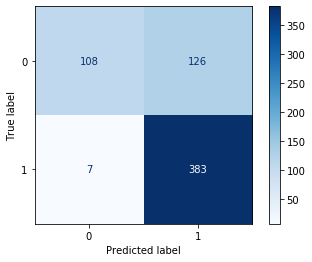

Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.46      0.62       234
           1       0.75      0.98      0.85       390

   micro avg       0.79      0.79      0.79       624
   macro avg       0.85      0.72      0.74       624
weighted avg       0.82      0.79      0.76       624
 


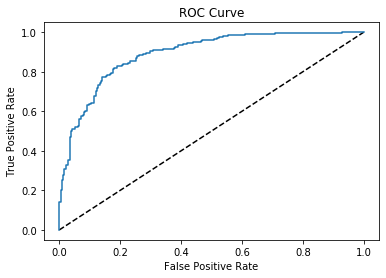

Threshold value is: 0.9577817107271048
AUC Score is : 0.8904887135656367


In [35]:
display_model(y_test,y_pred,'SVC:Testing')
plot_confusion_matrix(classifier, X_test_PCA,y_test,cmap=plt.cm.Blues) 
plt.show()  
print("Classification Report : \n %s " % classification_report(y_test, y_pred, labels=[0,1]))
y_pred_prob1 = classifier.predict_proba(X_test_PCA)[:,1]
roc(y_test,y_pred_prob1)

<b>Observation:</b>Out of 390 Pneumonia images 382 images has been correctly identified. Accuracy using SVM is 78% . AUC Score is 89%.
    Recall for Pneumonia is 98%

# Decision Tree

Decision tree uses the tree representation to solve the problem in which each leaf node corresponds to a class label and attributes are represented on the internal node of the tree.

#############  Decision Tree Model  ##################
########## Model=  Decision Tree :Testing ############# 

Confusion matrix:cf=
 [[122 112]
 [ 49 341]] 

Accuracy Score:acc= 0.7419871794871795 



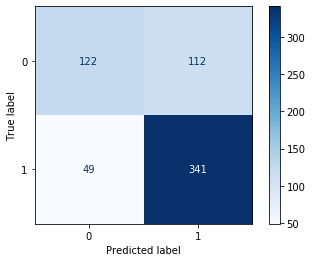

Classification Report : 
               precision    recall  f1-score   support

           0       0.71      0.52      0.60       234
           1       0.75      0.87      0.81       390

   micro avg       0.74      0.74      0.74       624
   macro avg       0.73      0.70      0.71       624
weighted avg       0.74      0.74      0.73       624
 


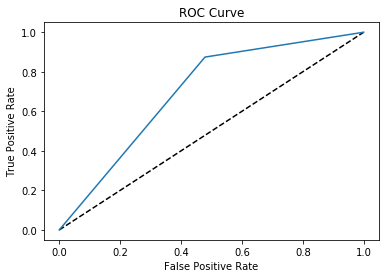

Threshold value is: 1.0
AUC Score is : 0.6978632478632478


In [36]:
################## Decision Tree ######################
print("#############  Decision Tree Model  ##################")
# Building Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train_PCA,y_train_under)

# Predicting the model on test data
pred_dt=dt.predict(X_test_PCA)
display_model(y_test,pred_dt,'Decision Tree :Testing')
plot_confusion_matrix(dt, X_test_PCA,y_test,cmap=plt.cm.Blues) 
plt.show()  
print("Classification Report : \n %s " % classification_report(y_test, pred_dt, labels=[0,1]))
y_pred_prob2 = dt.predict_proba(X_test_PCA)[:,1]
roc(y_test,y_pred_prob2)

<b>Observation:</b><br>
    Accuracy Score for Decision Tree is 74% . Out of 390 pneumonia images 341 images has been correctly classified. Out of 234 normal images 122 images has been correctly classified. Recall is 87%.AUC Score is 69.7%

# Random Forest

Random forest is an ensemble learning method for classification.<br>
The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by voting is more accurate than that of any individual tree.

In [61]:
#Hyperparameter tuning
model = RandomForestClassifier()
n_estimators = [10, 100, 200]
max_features = ['sqrt', 'log2']
max_depth=[10,20,40,60]
min_samples_split = [2,4,6]
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split,max_depth=max_depth)
grid_search = GridSearchCV(estimator=model, param_grid=grid,scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_PCA, y_train_under)
grid_search.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 200}

##########  Random Forest Model  ##################
########## Model=  Random Forest :Testing ############# 

Confusion matrix:cf=
 [[117 117]
 [ 28 362]] 

Accuracy Score:acc= 0.7676282051282052 



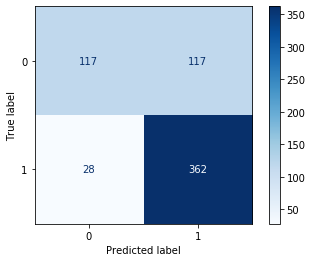

Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.50      0.62       234
           1       0.76      0.93      0.83       390

   micro avg       0.77      0.77      0.77       624
   macro avg       0.78      0.71      0.73       624
weighted avg       0.77      0.77      0.75       624
 


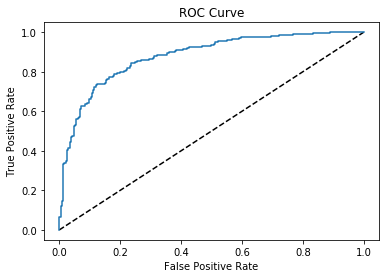

Threshold value is: 0.5957199272742193
AUC Score is : 0.8785557747096208


In [64]:
#########Random Forest ###################33
print("##########  Random Forest Model  ##################")
# Building Random Forest model
rf = RandomForestClassifier(max_features='sqrt', n_estimators= 200,min_samples_split=4,max_depth=10,random_state=42)
#rf = RandomForestClassifier(max_features='log2', n_estimators= 1000,min_samples_split=4,random_state=42)
rf.fit(X_train_PCA,y_train_under)
# Predicting the model on test data
predictions_rf = rf.predict(X_test_PCA)
display_model(y_test,predictions_rf,'Random Forest :Testing')
plot_confusion_matrix(rf, X_test_PCA,y_test,cmap=plt.cm.Blues) 
plt.show()  
print("Classification Report : \n %s " % classification_report(y_test,predictions_rf, labels=[0,1]))
y_pred_prob3 = rf.predict_proba(X_test_PCA)[:,1]
roc(y_test,y_pred_prob3)

<b>Observation:</b><br>
    Accuracy Score for Random Forest is 76% and the AUC Score is 87% . Out of 390 pneumonia images 362 images has been classified correctly.Recall is 93%

# KNN

KNN algorithms is a supervised algorithm which classify the data points based on similarity measures (e.g. distance function). Classification is done by a majority vote to its neighbors.

[123, 102, 117, 104, 124, 119, 126, 119, 126, 123, 128, 121, 121, 112, 119, 120, 123, 120, 123]


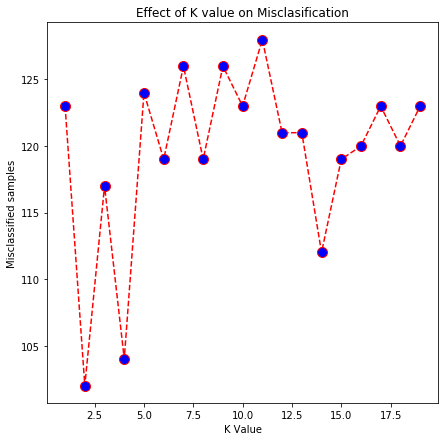

In [39]:
#Effect of K value on classifier
""
Misclassified_sample = []
# Calculating error for K values between 1 and 40
for i in range(1, 20):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_PCA,y_train_under)
    pred_i = knn.predict(X_test_PCA)
    Misclassified_sample.append((y_test != pred_i).sum())

print(Misclassified_sample)


# Plotting the effect of K 
plt.figure(figsize = (7,7))
plt.plot(range(1,20,1),Misclassified_sample, 
         color='red',linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)

plt.title('Effect of K value on Misclasification')  
plt.xlabel('K Value')  
plt.ylabel('Misclassified samples')  
plt.show()

########## Model=  KNN : Testing ############# 

Confusion matrix:cf=
 [[164  70]
 [ 32 358]] 

Accuracy Score:acc= 0.8365384615384616 



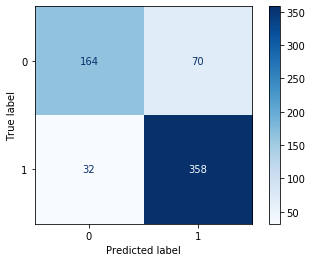

Classification Report : 
               precision    recall  f1-score   support

           0       0.84      0.70      0.76       234
           1       0.84      0.92      0.88       390

   micro avg       0.84      0.84      0.84       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.84      0.83       624
 


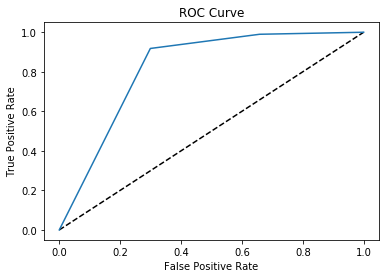

Threshold value is: 1.0
AUC Score is : 0.819833442910366
Misclassified samples: 102


In [40]:
# Storing the K nearest classifier
KNN_classifier = KNeighborsClassifier(n_neighbors = 2)  

# Fitting the values for X and Y
KNN_classifier.fit(X_train_PCA,y_train_under) 

# Predicting the test values with model
prediction = KNN_classifier.predict(X_test_PCA)

display_model(y_test,prediction,'KNN : Testing')
plot_confusion_matrix(KNN_classifier, X_test_PCA,y_test,cmap=plt.cm.Blues) 
plt.show()  
print("Classification Report : \n %s " % classification_report(y_test, prediction, labels=[0,1]))
y_pred_prob4 = KNN_classifier.predict_proba(X_test_PCA)[:,1]
roc(y_test,y_pred_prob4)

print('Misclassified samples: %d' % (y_test != prediction).sum())


<b>Observation:</b><br>
    Accuracy Score is 83% and AUC Sccore is 81.9% . Out of 390 Pneumonia Images 358 Images has been correctly classified.
    Misclassified number of samples is 102. Recall for Pnemonia is 92% and Precision is 84%

# ROC Curve : Comparison of Different Models

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate vs False Positive Rate.

True Positive Rate (TPR) also known as recall, TPR=TP/(TP+FN)<br>
False Positive Rate is FPR=FP/(FP+TN)

AUC stands for "Area under the ROC Curve" measures the entire two-dimensional area underneath the entire ROC curve.

In [65]:
#FPR and TPR of All Models
#FPR and TPR for SVM
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_prob1 , pos_label= '1')
#FPR and TPR for Decision Tree
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_prob2 , pos_label= '1')
#FPR and TPR for Random Forest
fpr3, tpr3, thresh3 = roc_curve(y_test, y_pred_prob3 , pos_label= '1')
#FPR and TPR for KNN
fpr4, tpr4, thresh4 = roc_curve(y_test, y_pred_prob4 , pos_label= '1')

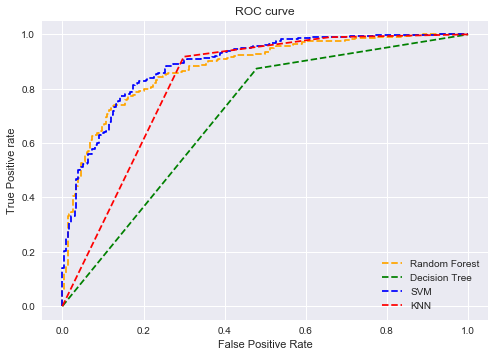

############### AUC Score for Different Models ##################

AUC Score for Random Forest: 0.8785557747096208
AUC Scorefor Decision Tree: 0.6978632478632478
AUC Score for SVM: 0.8904887135656367
AUC Score for KNN: 0.819833442910366


In [77]:
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr3, tpr3, linestyle='--',color='orange', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decision Tree')
plt.plot(fpr1, tpr1, linestyle='--',color='blue', label='SVM')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='KNN')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

#AUC Score for Different Models
print('############### AUC Score for Different Models ##################\n')
auc_score_RF = roc_auc_score(y_test, y_pred_prob3)
print("AUC Score for Random Forest: %s" % auc_score_RF)
auc_score_DT = roc_auc_score(y_test, y_pred_prob2)
print("AUC Scorefor Decision Tree: %s" % auc_score_DT)
auc_score_SVM = roc_auc_score(y_test, y_pred_prob1)
print("AUC Score for SVM: %s" % auc_score_SVM)
auc_score_KNN = roc_auc_score(y_test, y_pred_prob4)
print("AUC Score for KNN: %s" % auc_score_KNN)

<b>Observation:</b><br>From the above graph we can say out of all these ML algorithms SVM and Random Forest works better for this image dataset. AUC Score is the highest for SVM.<br>
    For disease diagonising it is important to correctly predict the true values.
    We cannot incorrectly diagnose a patient as normal when the true report shows that patient has pnemonia.So along with higher accuracy we need higher recall.Recall is higher for SVM Model.

# CNN Model

Convolutional Neural Network (CNN) is used for Image Classification . Keras library is used with Tensorflow backend to implement CNN.<br>
CNN is made up of hidden layers that are attached to a fully connected layer which handles the classification decisions based on the pixel information flowing through the previous layers.

In [68]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D, Flatten,Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

<b>Image Augmentation: </b> New samples are generated with the help of Image Augmentation. Already existing photos can be manipulated using techniques such as shearing,zooming,flipping etc.

In [69]:
#Defining two objects of the Image Data Generator to augment the existing images
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [70]:
training_set = train_datagen.flow_from_directory('C://Users//sreepa//Downloads//train',
                                                 target_size = (224, 224),
                                                 batch_size = 128,color_mode="grayscale",
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


Training dataset is augmented with new samples through rescaling,shearing,zooming and flipping.It is also rescaled and resized.

In [71]:
test_set = test_datagen.flow_from_directory('C://Users//sreepa//Downloads//test//test',
                                            target_size = (224, 224),
                                            batch_size = 128,color_mode="grayscale",
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


Test dataset is only rescaled and resized.

<b>CNN Model</b>: model is defined to be Sequential,ie, we append layers one by one.<br>
    - model.add is used to append layers.
    - It has Conv2D and MaxPooling2D layers.
    - In the first Convolutional layer the input shape is specified. In all other layers it will take the shape from the previous layers.
    - Activation function used in the Convolution layer is 'RELU' as it is faster.
    - In the output Dense Layer the activation function is 'sigmoid'.For binary classification sigmoid is used as activation function in the output layer.
    - Stride is a parameter of the neural network's filter that modifies the amount of movement over the image or video.Here I have given stride as 2 in second convolutional layer. So the filter will move two pixel, or unit, at a time.
    - Padding ='same' means using padding. When the stride is set as 1, the output size of the convolutional layer maintains as the input size by appending a certain number of '0-border' around the input data when calculating convolution.

In [72]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3,3), activation='relu',strides=2,padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))


model.compile configures the model for training with all the hyperparameters. Here the optimzer used is 'Adam'. For calculating the loss 'binary_crossentropy' is used.<br>
model.summary provides the summary of each layer including the number of trainable parameters.

In [73]:
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)       

<b>Observation</b><br>Number of trainable parameters is 142,529 . There are 6 Convolutional blocks. Each block has a convolution layer,and a max pooling layer. The activation function used in the convolution layer is 'Relu'.Since this is a binary classification for the output layer 'sigmoid' activation function is used.

model.fit is used to perform the training of the model.
Checkpoint is used to save the model weights in a folder so that we can use it for evaluation. Here I am saving only the best weight values.

In [74]:
checkpointer=ModelCheckpoint(filepath='model.weights.best.hdfs',verbose=1,save_best_only=True)
result=model.fit(x = training_set, validation_data = test_set, epochs = 10,batch_size=128,callbacks=[checkpointer])

Epoch 1/10
41/41 [==============================] - 69s 2s/step - loss: 0.6184 - accuracy: 0.7034 - precision: 0.7411 - recall: 0.9276 - val_loss: 0.6618 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.66184, saving model to model.weights.best.hdfs
INFO:tensorflow:Assets written to: model.weights.best.hdfs\assets
Epoch 2/10
41/41 [==============================] - 75s 2s/step - loss: 0.4902 - accuracy: 0.7640 - precision: 0.7667 - recall: 0.9838 - val_loss: 0.5426 - val_accuracy: 0.8013 - val_precision: 0.7628 - val_recall: 0.9897

Epoch 00002: val_loss improved from 0.66184 to 0.54256, saving model to model.weights.best.hdfs
INFO:tensorflow:Assets written to: model.weights.best.hdfs\assets
Epoch 3/10
41/41 [==============================] - 76s 2s/step - loss: 0.2720 - accuracy: 0.8874 - precision: 0.9159 - recall: 0.9352 - val_loss: 0.3048 - val_accuracy: 0.8894 - val_precision: 0.9105 - val_recall: 0.9128

Epoch 00003

<b>Observation: </b><br>Here I have given 10 epochs. Once all images are done with the forward and backward propogation it is called an Epoch.<br>
    val_loss was better at fifth Epoch and is 0.29243

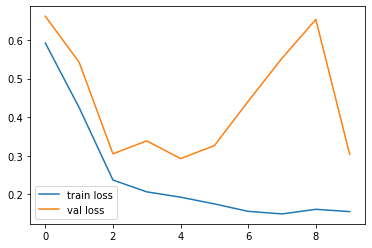

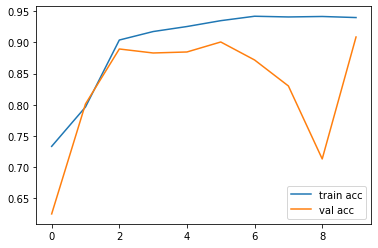

In [75]:
# plot the loss for both train and test dataset
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plot the accuracy for both train and test dataset
plt.plot(result.history['accuracy'], label='train acc')
plt.plot(result.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [76]:
#Evaluating the model using the best saved weights.
eval_result1 = model.evaluate(test_set)
print('loss  :', eval_result1[0])
print('accuracy  :', eval_result1[1])
print('Precision :', eval_result1[2])
print('Recall :', eval_result1[3])

5/5 [==============================] - 3s 668ms/step - loss: 0.3036 - accuracy: 0.9087 - precision: 0.9051 - recall: 0.9538
loss  : 0.3036203682422638
accuracy  : 0.9086538553237915
Precision : 0.9051094651222229
Recall : 0.9538461565971375


<b>Observation: </b>
    
    Train and Test data has almost similar loss and accuracy. The accuracy is 90.8% and Recall is 95% .So we can say that CNN model works better than all the other ML models.

<b>Conclusion :</b><br> 
    - Dataset is highly imbalanced.I tried SVM with weighted class for the imbalance dataset and got an accuracy of 72%.
    - Accuracy and AUC Score got after upsampling is low.
    - After downsampling applied different classification methods and Out of those SVM and Random Forest works better for this dataset.
    - KNN Model has the better F1 Score.It also has the higher accuracy but the AUC Score is 81% which is lower than RandomForest and SVM.
    - Applied CNN and it works better for Image Classification.
    - In medical daignosis it is very important to correctly predict the true values.We cannot incorrectly diagnose a patient as normal when the patient has pnemonia.So along with higher accuracy we need higher recall.
    - Accuracy for test data after applying CNN is 90.8 % , Precision is 90.5% and Recall is 95.38 %
    